In [1]:
import numpy as np
from matplotlib import pyplot as plt
from time import time
import os
import cv2

%matplotlib inline

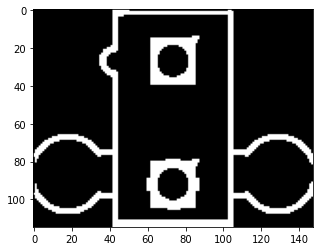

In [2]:
power_supply = np.load('./data/components/power_supply.npy')
plt.imshow(power_supply, cmap='gray')

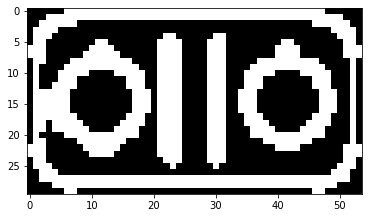

In [3]:
capacitance = np.load('./data/components/capacitance.npy')
plt.imshow(capacitance, cmap='gray')

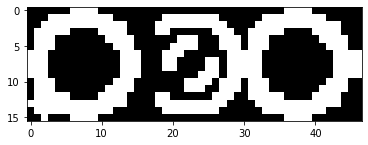

In [4]:
LED = np.load('./data/components/LED.npy')
plt.imshow(LED, cmap='gray')

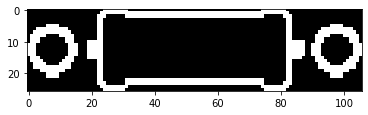

In [5]:
resistance = np.load('./data/components/resistance.npy')
plt.imshow(resistance, cmap='gray')

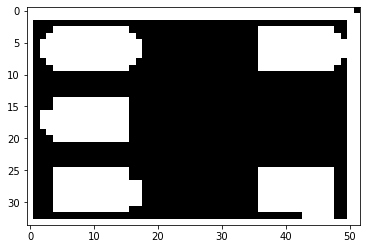

In [6]:
regulation = np.load('./data/components/regulation.npy')
plt.imshow(regulation, cmap='gray')

In [82]:
def get_threshold_gray_img(input_file):
    """
    get the thresholded image by OTSU's method 
    """
    img = cv2.imread(input_file)
    assert img is not None
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU) 
    return thresh


def crop(diagram):
    """
    Crop the empty starting and ending rows and cols to reduce search space
    """
    start_row, start_col, end_row, end_col = 0, 0, len(diagram)-1, len(diagram[0])-1
    while np.sum(diagram[start_row]) == 0:
        start_row += 1
        if start_row == len(diagram):
            return None, None
    while np.sum(diagram[:, start_col]) == 0:
        start_col += 1
    while np.sum(diagram[end_row]) == 0:
        end_row -= 1
    while np.sum(diagram[:, end_col]) == 0:
        end_col -= 1
    return diagram[start_row:end_row+1, start_col:end_col+1], [start_row, start_col]


def get_next_boundary_component(img, debug=False, tol=12):
    """
    get the next connected component in img (assume input image is cropped)
    tol: maximum distance of a neighbor 
    """
    
    
    m, n = img.shape
    visited = set()
    all_boundary_ixs = []
    all_boundary_ixs += [(i, 0) for i in range(m)]
    all_boundary_ixs += [(i, n-1) for i in range(m)]
    all_boundary_ixs += [(0, j) for j in range(n)]
    all_boundary_ixs += [(m-1, j) for j in range(n)]
    start_ix = next(ix for ix in all_boundary_ixs if img[ix[0], ix[1]] > 0)
    
    
    queue = []
    queue.append(start_ix)
    visited.add(start_ix)
    while queue:
        i, j = queue.pop()
        for ni in range(i-tol, i+tol+1):
            for nj in range(j-tol, j+tol+1): # squared search (as effective as linear)
                if ni < 0 or nj < 0 or ni >= m or nj >= n:
                    continue
                if (ni, nj) in visited or img[ni, nj] == 0:
                    continue
                visited.add((ni, nj))
                queue.append((ni, nj))
    
    
    start_row = min(x[0] for x in visited)
    end_row = max(x[0] for x in visited)
    start_col = min(x[1] for x in visited)
    end_col = max(x[1] for x in visited)
    if debug:
        plt.figure()
        plt.imshow(img[start_row:end_row+1, start_col:end_col+1], cmap='gray')
        
    res = np.array(img[start_row:end_row+1, start_col:end_col+1])
    img[start_row:end_row+1, start_col:end_col+1] = 0
    return res

def get_similarity(comp, mask):
    """
    Get similarity of component with mask of different shapes
    """
    resized_mask = cv2.resize(mask, comp.T.shape)
    assert(resized_mask.shape == comp.shape)
    return np.sum(comp==resized_mask) / comp.shape[0] / comp.shape[1]

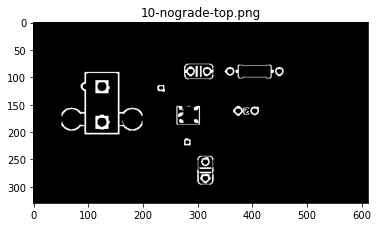

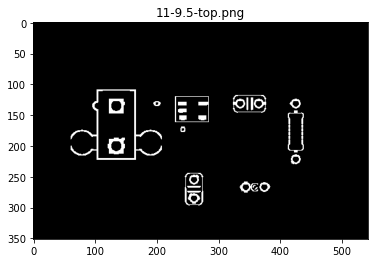

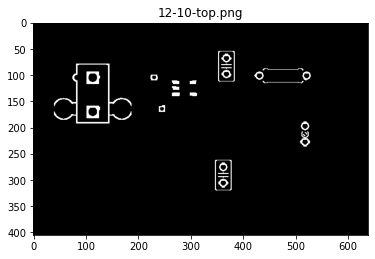

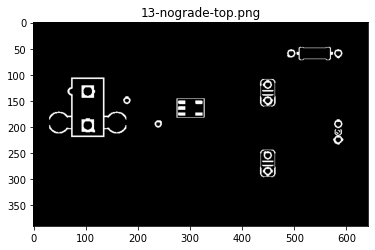

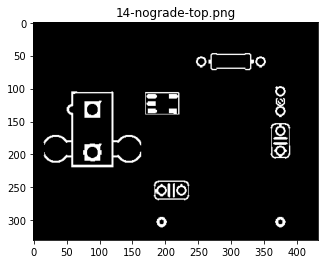

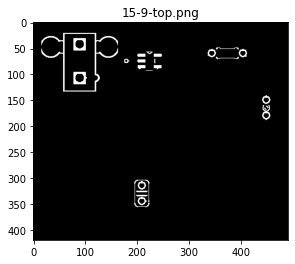

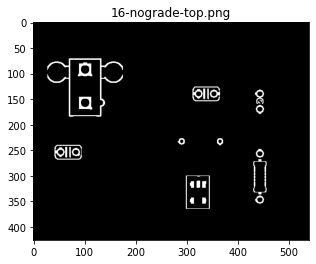

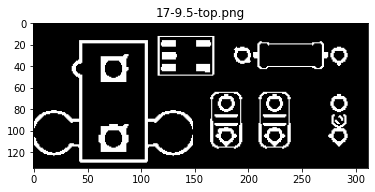

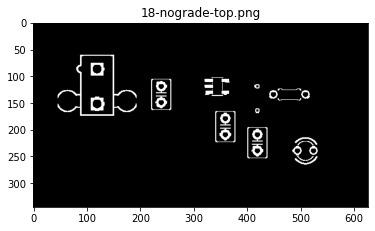

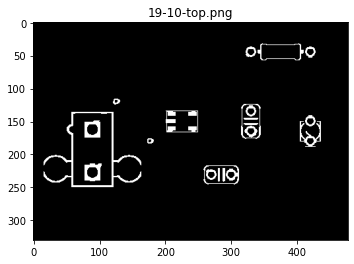

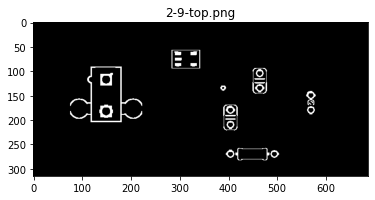

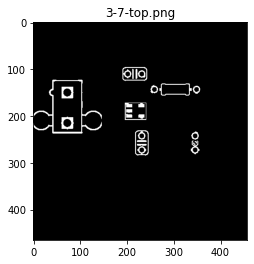

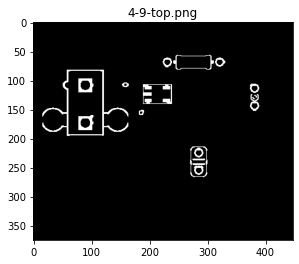

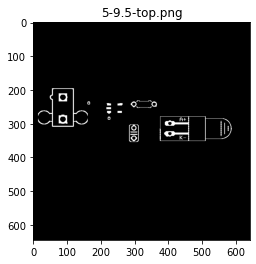

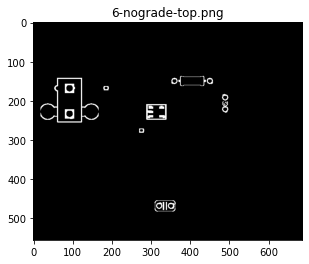

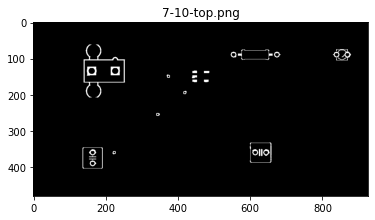

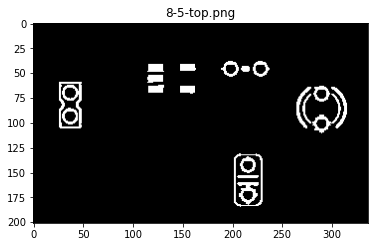

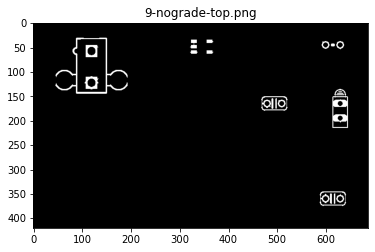

In [72]:
for f in os.listdir('data/processed_data'):
    if 'copper' not in f and 'top' in f:
        thresh = get_threshold_gray_img('data/processed_data/'+f)
        plt.figure()
        plt.title(f)
        plt.imshow(thresh, cmap='gray')

In [73]:
start_time = time()

all_components = {}
for f in os.listdir('data/processed_data'):
    if 'copper' not in f and 'top' in f:
        print(f)
        thresh = get_threshold_gray_img('data/processed_data/'+f)
        cropped_diagram, offsets = crop(thresh)
        curr_components = []
        while cropped_diagram is not None:
            curr_components.append(get_next_boundary_component(cropped_diagram, tol=6, debug=False))
            cropped_diagram = crop(cropped_diagram)[0]
        all_components[f] = curr_components
        
print(f'{time()-start_time}s elapsed')

10-nograde-top.png
11-9.5-top.png
12-10-top.png
13-nograde-top.png
14-nograde-top.png
15-9-top.png
16-nograde-top.png
17-9.5-top.png
18-nograde-top.png
19-10-top.png
2-9-top.png
3-7-top.png
4-9-top.png
5-9.5-top.png
6-nograde-top.png
7-10-top.png
8-5-top.png
9-nograde-top.png
13.721311807632446s elapsed


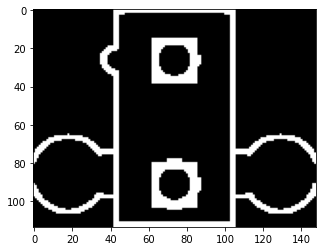

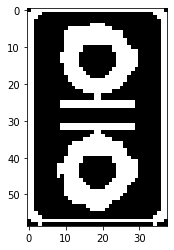

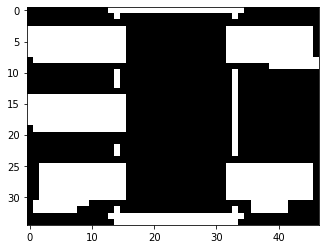

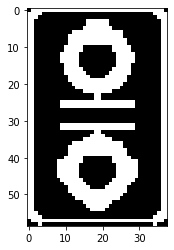

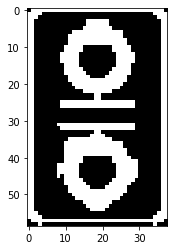

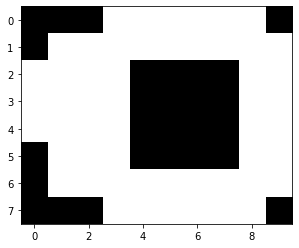

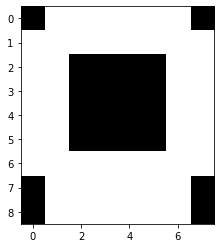

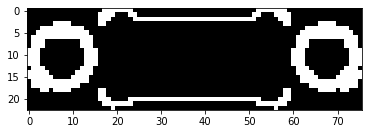

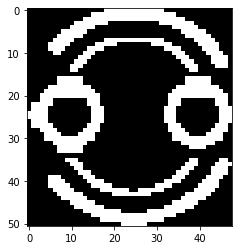

In [74]:
for comp in all_components['18-nograde-top.png']:
    plt.figure()
    plt.imshow(comp, cmap='gray')

# Power Supply Experiment

In [75]:
all_power_supplys = []
rot_power_supply = np.array(power_supply)
for i in range(4):
    all_power_supplys.append(rot_power_supply)
    rot_power_supply = np.rot90(rot_power_supply)

10-nograde-top.png: found power supply
11-9.5-top.png: found power supply
12-10-top.png: found power supply
13-nograde-top.png: found power supply
14-nograde-top.png: found power supply
15-9-top.png: found power supply
16-nograde-top.png: found power supply
17-9.5-top.png: found power supply
18-nograde-top.png: found power supply
19-10-top.png: found power supply
2-9-top.png: found power supply
3-7-top.png: found power supply
4-9-top.png: found power supply
5-9.5-top.png: found power supply
6-nograde-top.png: found power supply
7-10-top.png: found power supply
9-nograde-top.png: found power supply


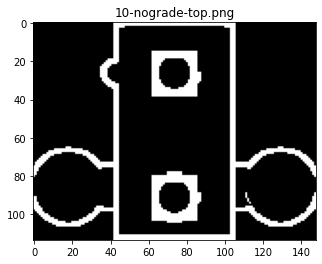

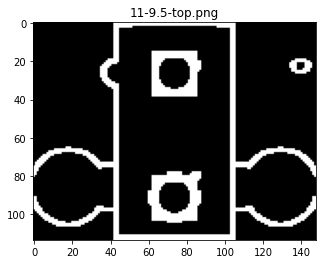

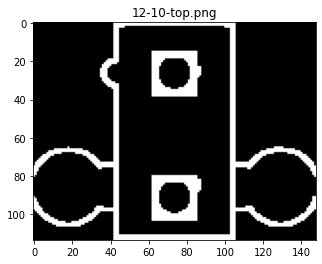

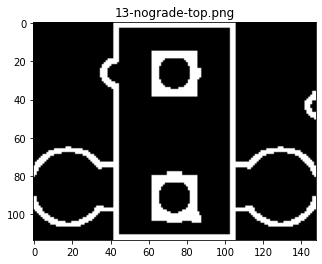

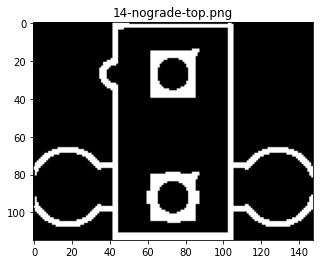

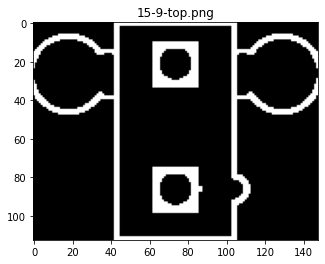

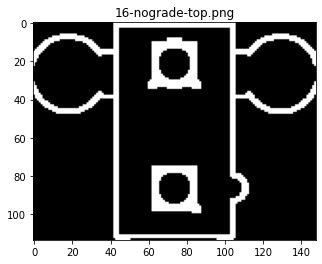

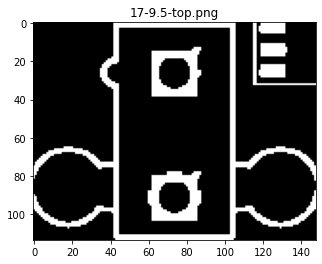

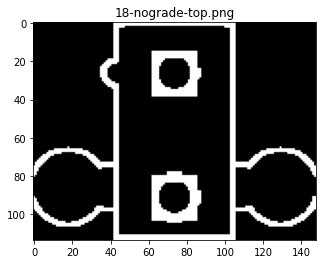

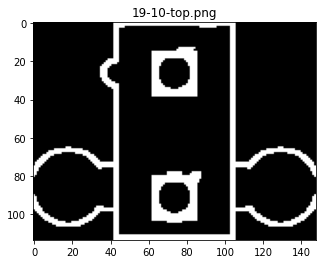

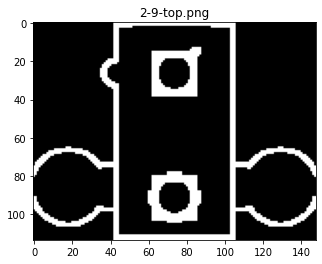

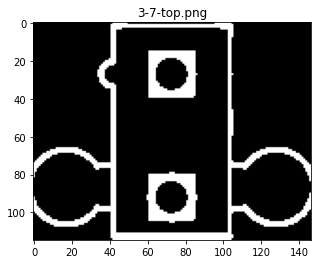

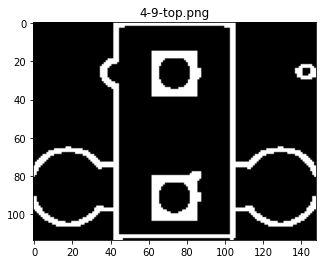

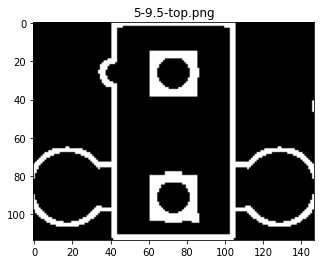

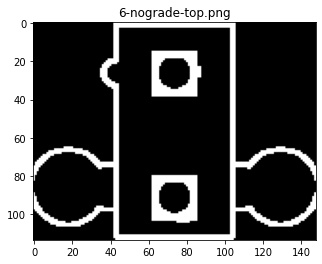

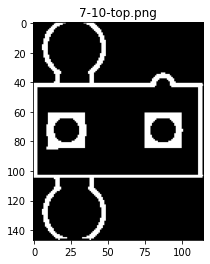

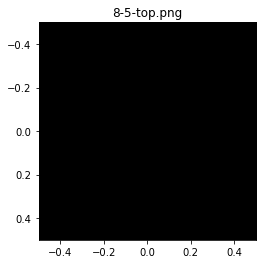

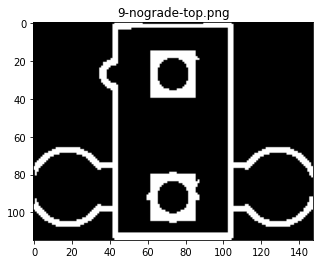

In [76]:
for f in os.listdir('data/processed_data'):
    if 'copper' not in f and 'top' in f:
        best_match = np.zeros((1, 1))
        for comp in all_components[f]:
            for rot_power_supply in all_power_supplys:
                if get_similarity(comp, rot_power_supply) > 0.9:
                    print(f'{f}: found power supply')
                    best_match = comp
        plt.figure()
        plt.title(f)
        plt.imshow(best_match, cmap='gray')

# Capacitance

In [77]:
all_capacitances = []
rot_cap = np.array(capacitance)
for i in range(4):
    all_capacitances.append(rot_cap)
    rot_cap = np.rot90(rot_cap)

14-nograde-top.png: found capacitances
14-nograde-top.png: found capacitances
9-nograde-top.png: found capacitances
9-nograde-top.png: found capacitances


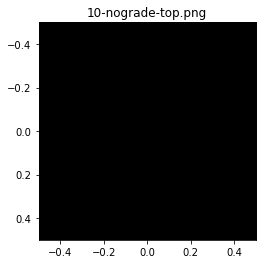

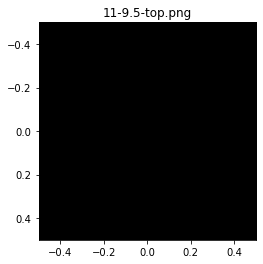

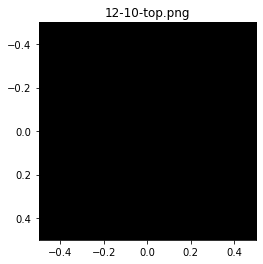

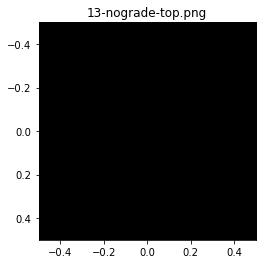

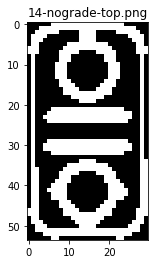

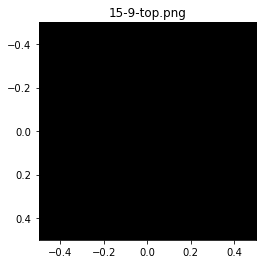

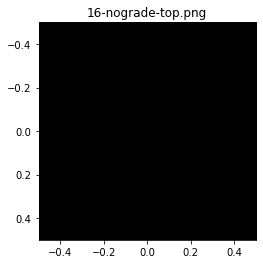

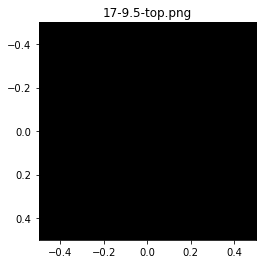

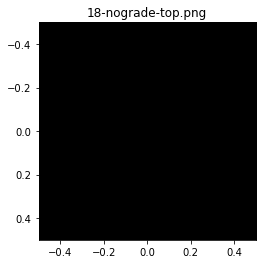

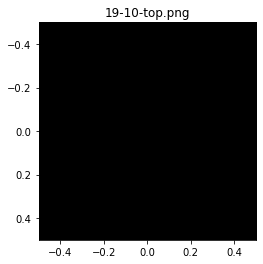

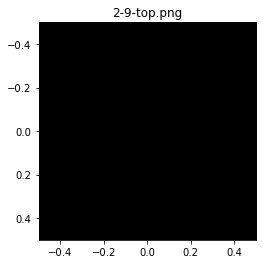

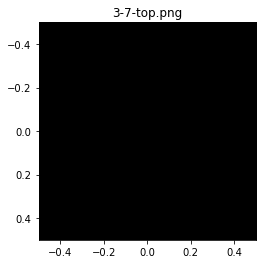

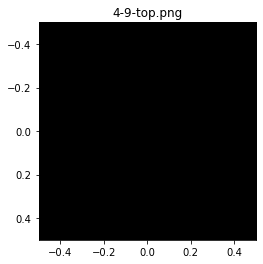

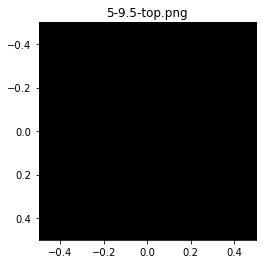

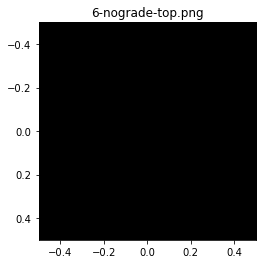

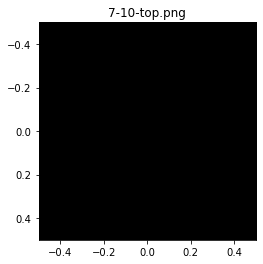

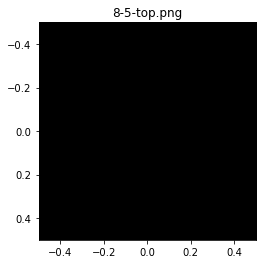

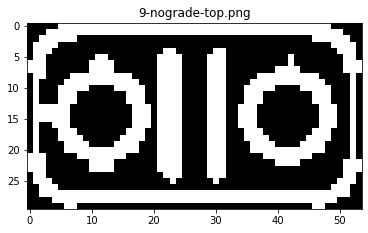

In [78]:
for f in os.listdir('data/processed_data'):
    if 'copper' not in f and 'top' in f:
        best_match = np.zeros((1, 1))
        for comp in all_components[f]:
            for rot_cap in all_capacitances:
                if get_similarity(comp, rot_cap) > 0.9:
                    print(f'{f}: found capacitances')
                    best_match = comp
        plt.figure()
        plt.title(f)
        plt.imshow(best_match, cmap='gray')

# Regulation

14-nograde-top.png: found regulator


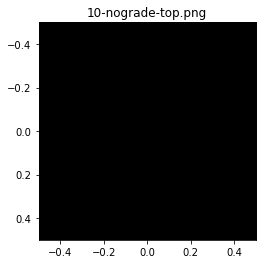

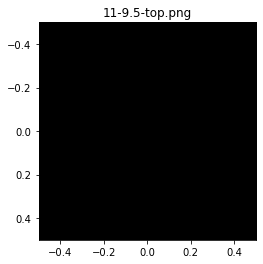

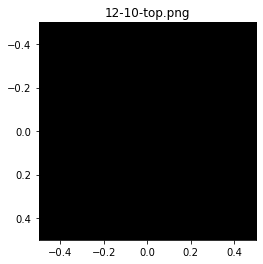

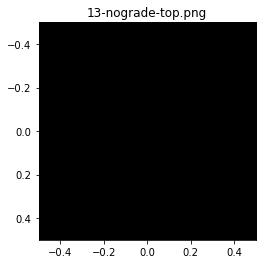

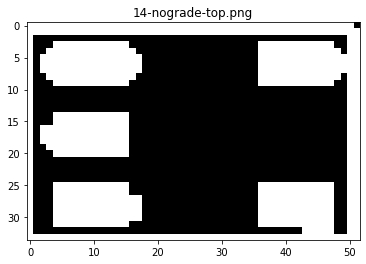

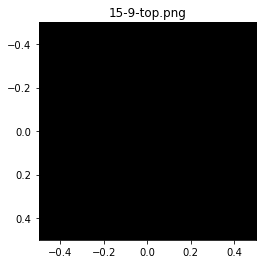

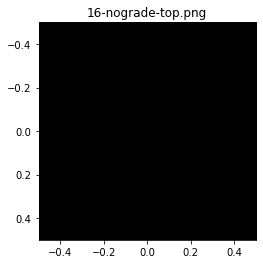

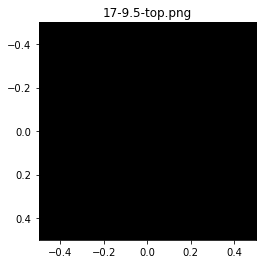

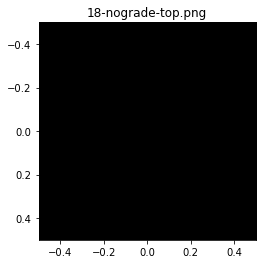

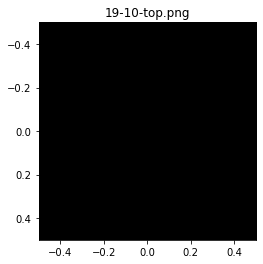

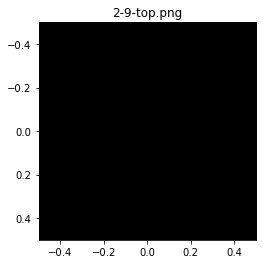

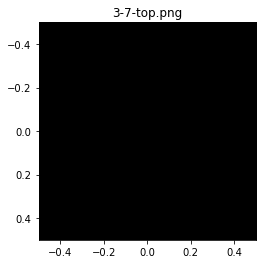

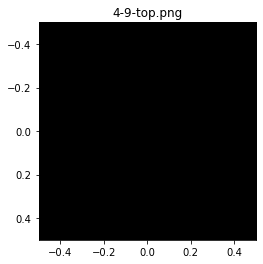

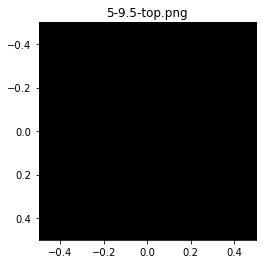

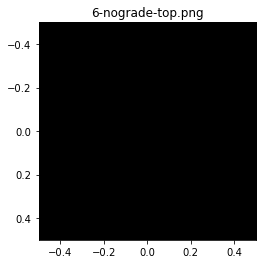

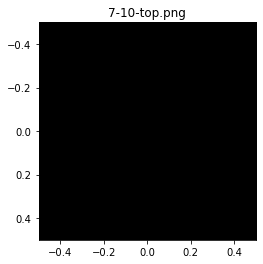

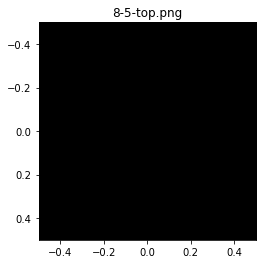

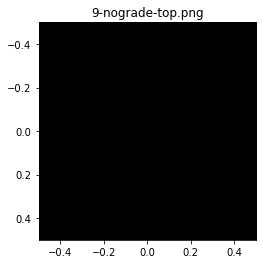

In [79]:
all_regulations = []
rot_reg = np.array(regulation)
for i in range(4):
    all_regulations.append(rot_reg)
    rot_reg = np.rot90(rot_reg)
    
for f in os.listdir('data/processed_data'):
    if 'copper' not in f and 'top' in f:
        best_match = np.zeros((1, 1))
        for comp in all_components[f]:
            for rot_reg in all_regulations:
                if get_similarity(comp, rot_reg) > 0.9:
                    print(f'{f}: found regulator')
                    best_match = comp
        plt.figure()
        plt.title(f)
        plt.imshow(best_match, cmap='gray')

# LED

14-nograde-top.png: found LED
4-9-top.png: found LED


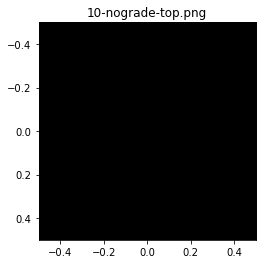

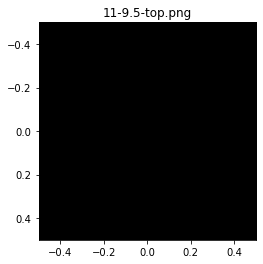

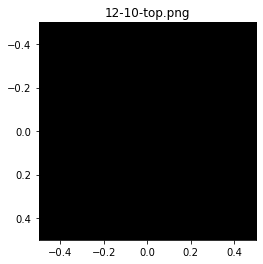

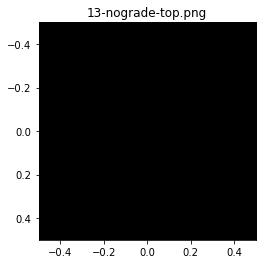

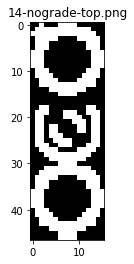

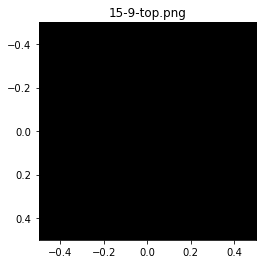

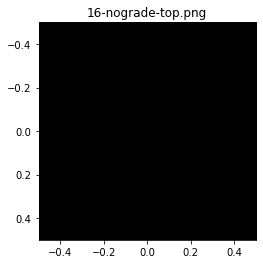

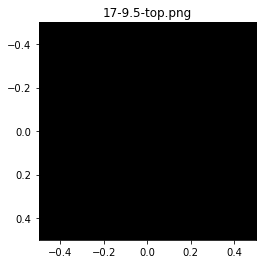

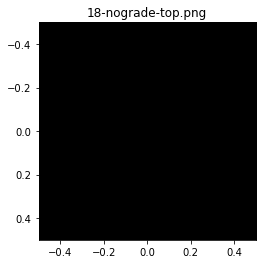

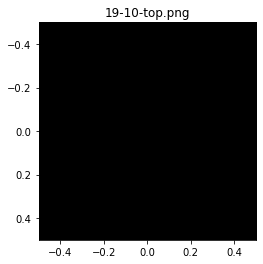

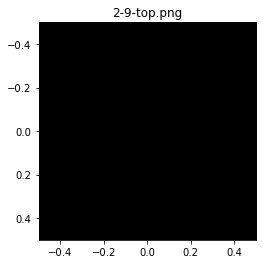

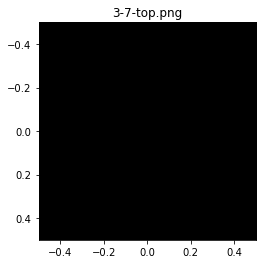

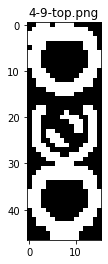

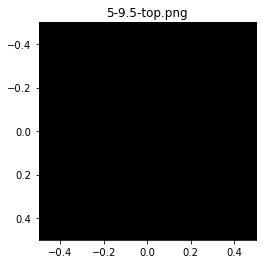

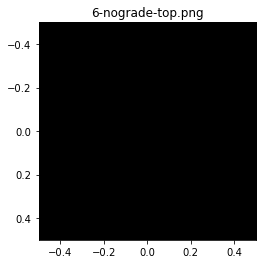

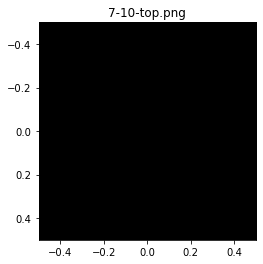

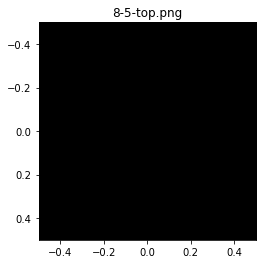

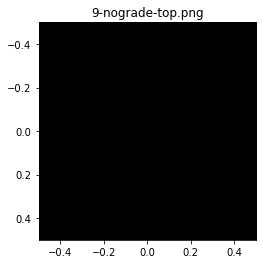

In [80]:
all_LED = []
rot_led = np.array(LED)
for i in range(4):
    all_LED.append(rot_led)
    rot_led = np.rot90(rot_led)
    
for f in os.listdir('data/processed_data'):
    if 'copper' not in f and 'top' in f:
        best_match = np.zeros((1, 1))
        for comp in all_components[f]:
            for rot_led in all_LED:
                if get_similarity(comp, rot_led) > 0.9:
                    print(f'{f}: found LED')
                    best_match = comp
        plt.figure()
        plt.title(f)
        plt.imshow(best_match, cmap='gray')

# Resistance

11-9.5-top.png: found resistance
11-9.5-top.png: found resistance
13-nograde-top.png: found resistance
13-nograde-top.png: found resistance
14-nograde-top.png: found resistance
14-nograde-top.png: found resistance
17-9.5-top.png: found resistance
17-9.5-top.png: found resistance
19-10-top.png: found resistance
19-10-top.png: found resistance
3-7-top.png: found resistance
3-7-top.png: found resistance
6-nograde-top.png: found resistance
6-nograde-top.png: found resistance


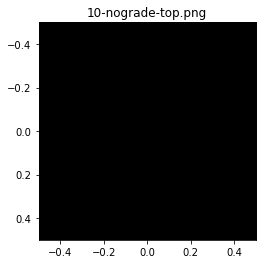

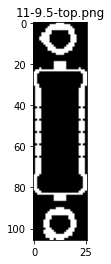

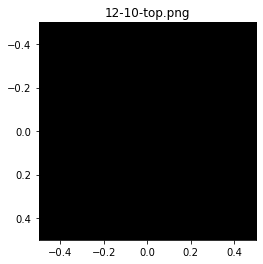

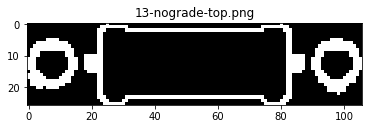

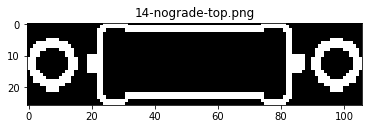

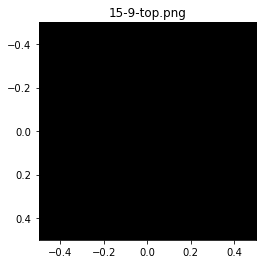

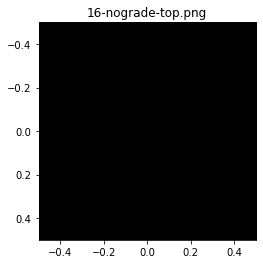

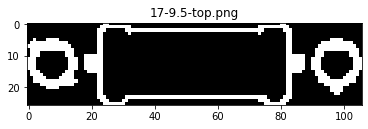

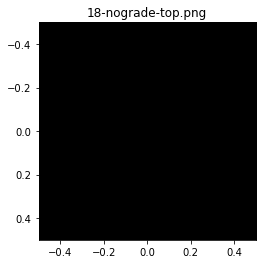

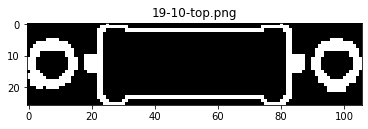

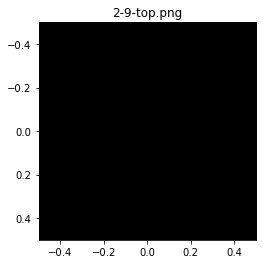

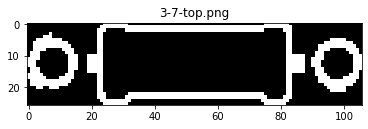

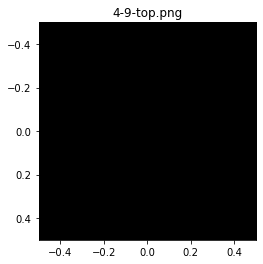

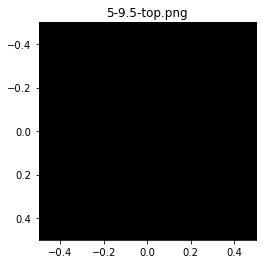

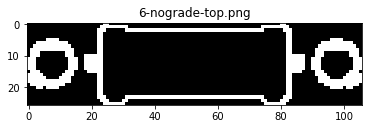

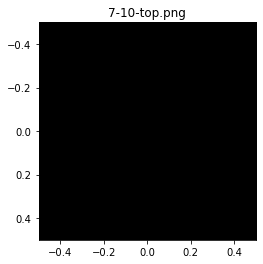

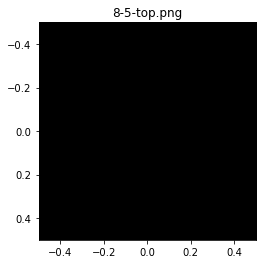

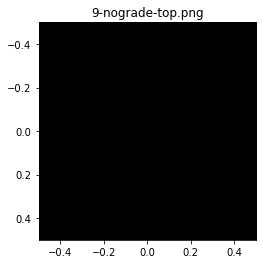

In [81]:
all_resistance = []
rot_resist = np.array(resistance)
for i in range(4):
    all_resistance.append(rot_resist)
    rot_resist = np.rot90(rot_resist)
    
for f in os.listdir('data/processed_data'):
    if 'copper' not in f and 'top' in f:
        best_match = np.zeros((1, 1))
        for comp in all_components[f]:
            for rot_resist in all_resistance:
                if get_similarity(comp, rot_resist) > 0.9:
                    print(f'{f}: found resistance')
                    best_match = comp
        plt.figure()
        plt.title(f)
        plt.imshow(best_match, cmap='gray')